In [23]:

import itertools
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

In [3]:

df = pd.read_csv('airline-passengers.csv', index_col='month', parse_dates=True)
df.shape
df.head()

,total_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


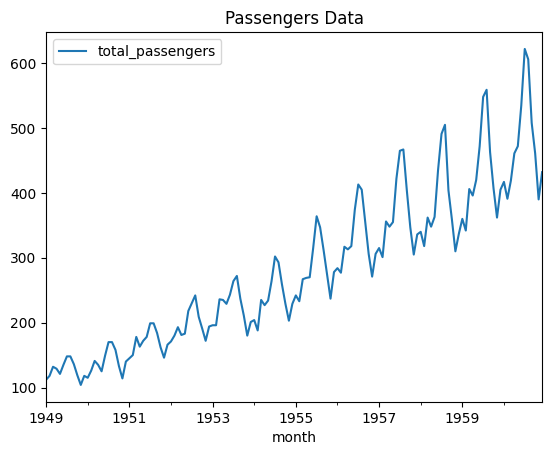

In [4]:
df[['total_passengers']].plot(title='Passengers Data')
plt.show()


In [5]:
df.index.freq = "MS"

In [6]:
train = df[:120]
test = df[120:]

In [8]:
#Dickey-Fuller Test
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")


In [9]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

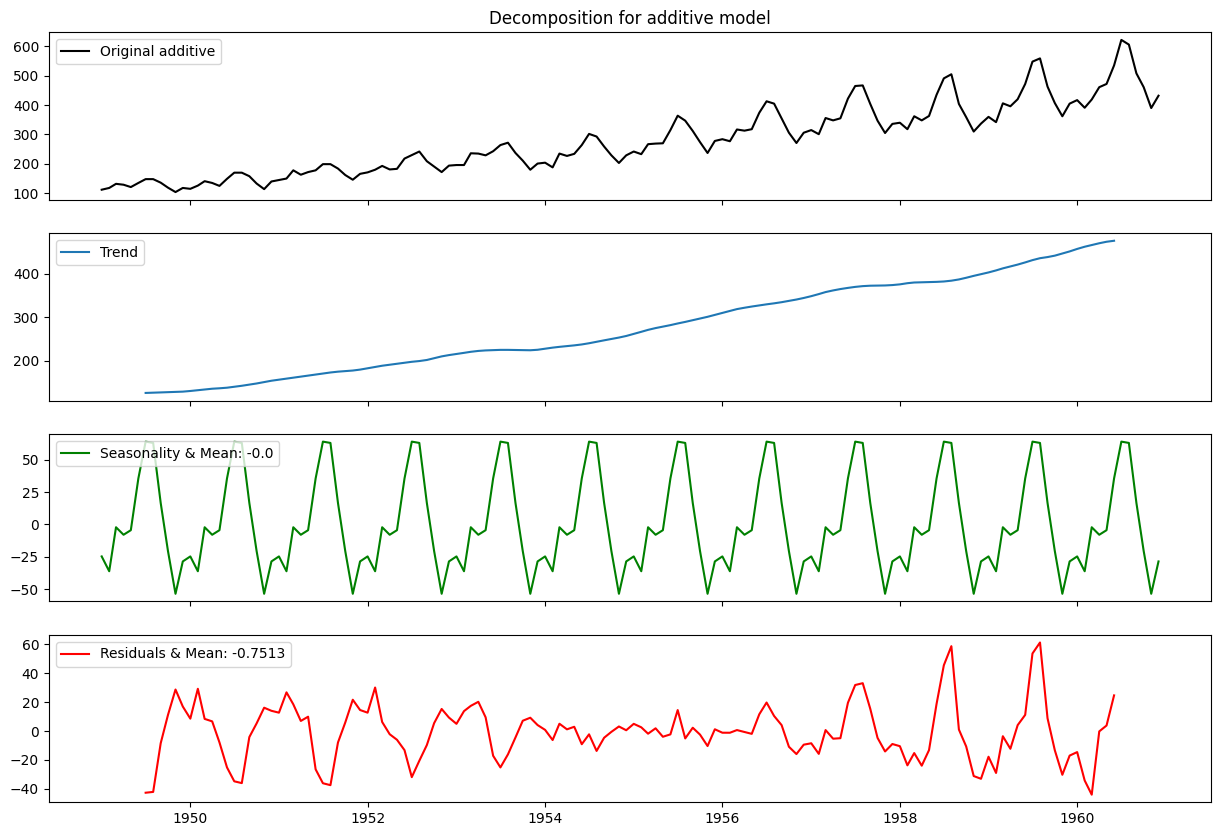

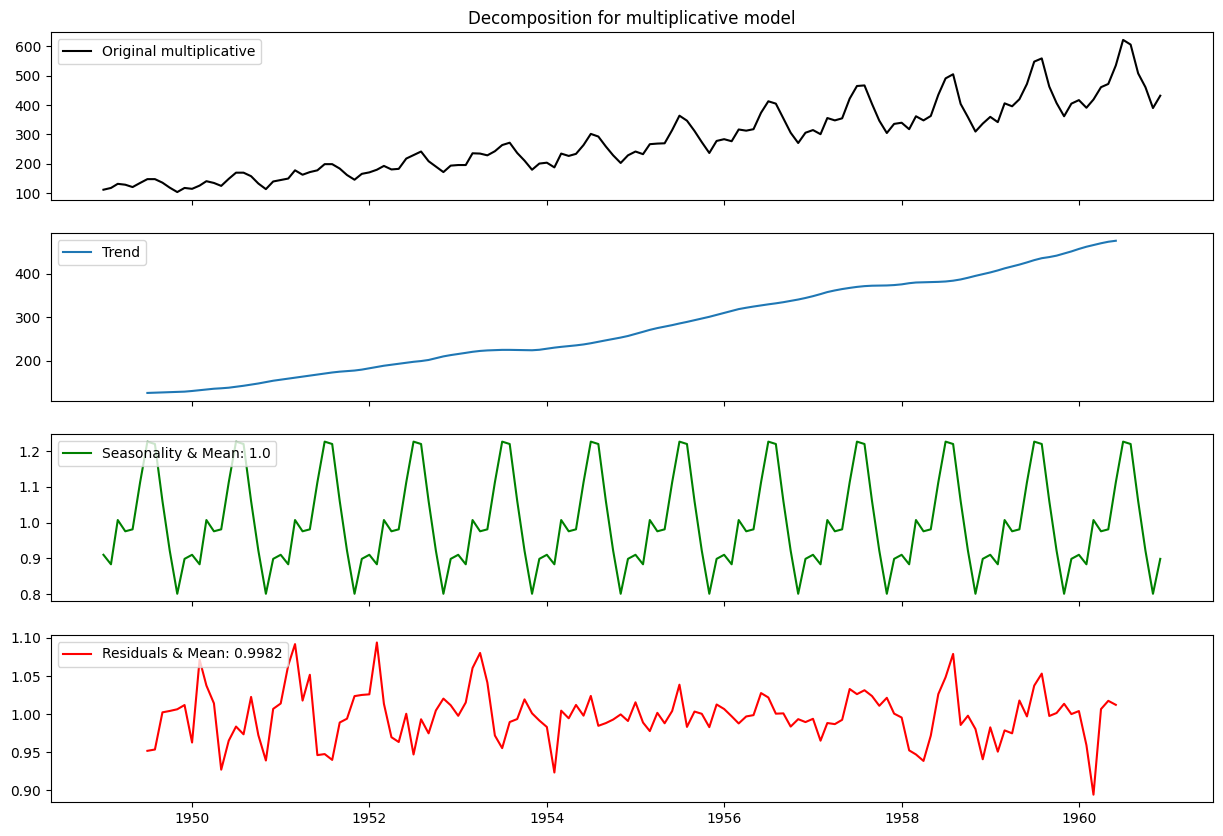

In [10]:
for model in ["additive", "multiplicative"]:
    ts_decompose(df, model)


In [11]:

#################################
# Single Exponential Smoothing
#################################

def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train, alphas, step=24)
# alpha: 0.11 mae: 82.528

ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(24)


alpha: 0.01 mae: 225.5863
alpha: 0.11 mae: 82.528
alpha: 0.21 mae: 82.8979
alpha: 0.31 mae: 89.8377
alpha: 0.41 mae: 99.0585
alpha: 0.51 mae: 107.5558
alpha: 0.61 mae: 113.7514
alpha: 0.71 mae: 117.2224
alpha: 0.81 mae: 118.1776
alpha: 0.91 mae: 117.2438
best_alpha: 0.11 best_mae: 82.528


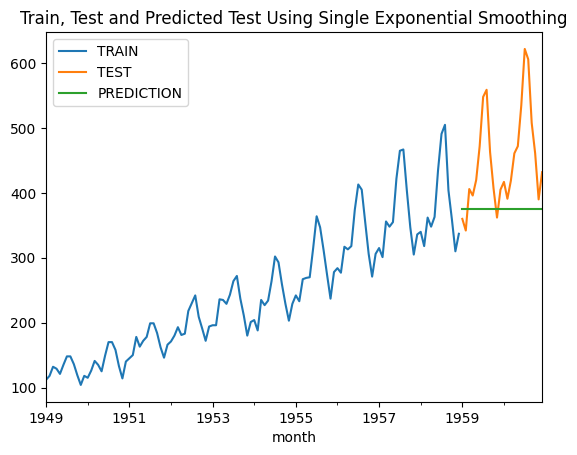

In [12]:

def plot_prediction(y_pred, label):
    train["total_passengers"].plot(legend=True, label="TRAIN")
    test["total_passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")


alpha: 0.01 beta: 0.01 mae: 54.9512
alpha: 0.01 beta: 0.11 mae: 54.1036
alpha: 0.01 beta: 0.21 mae: 55.5568
alpha: 0.01 beta: 0.31 mae: 57.3247
alpha: 0.01 beta: 0.41 mae: 57.7931
alpha: 0.01 beta: 0.51 mae: 57.9968
alpha: 0.01 beta: 0.61 mae: 57.9637
alpha: 0.01 beta: 0.71 mae: 57.5635
alpha: 0.01 beta: 0.81 mae: 57.3334
alpha: 0.01 beta: 0.91 mae: 57.8983
alpha: 0.11 beta: 0.01 mae: 55.0309
alpha: 0.11 beta: 0.11 mae: 58.4728
alpha: 0.11 beta: 0.21 mae: 69.6339
alpha: 0.11 beta: 0.31 mae: 72.555
alpha: 0.11 beta: 0.41 mae: 78.8168
alpha: 0.11 beta: 0.51 mae: 81.996
alpha: 0.11 beta: 0.61 mae: 77.2262
alpha: 0.11 beta: 0.71 mae: 71.5042
alpha: 0.11 beta: 0.81 mae: 69.0258
alpha: 0.11 beta: 0.91 mae: 67.8408
alpha: 0.21 beta: 0.01 mae: 57.1824
alpha: 0.21 beta: 0.11 mae: 74.992
alpha: 0.21 beta: 0.21 mae: 95.9492
alpha: 0.21 beta: 0.31 mae: 115.3164
alpha: 0.21 beta: 0.41 mae: 139.4303
alpha: 0.21 beta: 0.51 mae: 178.3759
alpha: 0.21 beta: 0.61 mae: 243.4543
alpha: 0.21 beta: 0.71 mae:

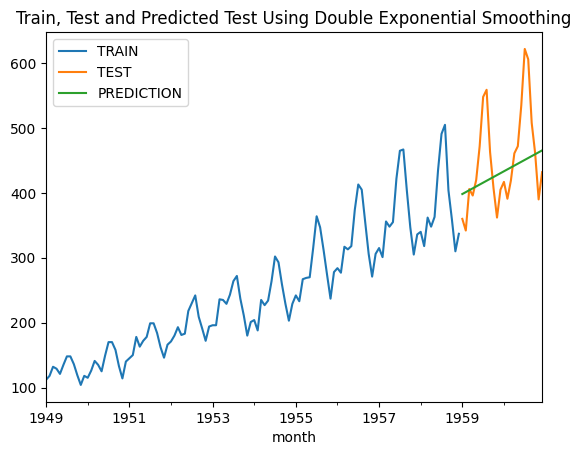

In [13]:
#################################
# Double Exponential Smoothing
#################################

def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae


alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=24)
# 54.10

des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(24)

plot_prediction(y_pred, "Double Exponential Smoothing")


[0.1, 0.1, 0.1, 36.83]
[0.1, 0.1, 0.3, 34.88]
[0.1, 0.1, 0.5, 35.91]
[0.1, 0.1, 0.7, 38.72]
[0.1, 0.1, 0.9, 42.55]
[0.1, 0.3, 0.1, 53.96]
[0.1, 0.3, 0.3, 53.0]
[0.1, 0.3, 0.5, 56.98]
[0.1, 0.3, 0.7, 61.38]
[0.1, 0.3, 0.9, 67.17]
[0.1, 0.5, 0.1, 56.76]
[0.1, 0.5, 0.3, 51.72]
[0.1, 0.5, 0.5, 53.39]
[0.1, 0.5, 0.7, 60.08]
[0.1, 0.5, 0.9, 79.29]
[0.1, 0.7, 0.1, 34.04]
[0.1, 0.7, 0.3, 25.93]
[0.1, 0.7, 0.5, 27.81]
[0.1, 0.7, 0.7, 27.91]
[0.1, 0.7, 0.9, 38.32]
[0.1, 0.9, 0.1, 26.87]
[0.1, 0.9, 0.3, 25.32]
[0.1, 0.9, 0.5, 53.88]
[0.1, 0.9, 0.7, 38.38]
[0.1, 0.9, 0.9, 17.78]
[0.3, 0.1, 0.1, 54.54]
[0.3, 0.1, 0.3, 38.34]
[0.3, 0.1, 0.5, 31.57]
[0.3, 0.1, 0.7, 30.99]
[0.3, 0.1, 0.9, 29.23]
[0.3, 0.3, 0.1, 72.71]
[0.3, 0.3, 0.3, 22.6]
[0.3, 0.3, 0.5, 11.99]
[0.3, 0.3, 0.7, 17.11]
[0.3, 0.3, 0.9, 22.32]
[0.3, 0.5, 0.1, 132.33]
[0.3, 0.5, 0.3, 25.74]
[0.3, 0.5, 0.5, 17.3]
[0.3, 0.5, 0.7, 38.38]
[0.3, 0.5, 0.9, 56.82]
[0.3, 0.7, 0.1, 288.32]
[0.3, 0.7, 0.3, 134.86]
[0.3, 0.7, 0.5, 96.77]
[0.3, 0.7, 

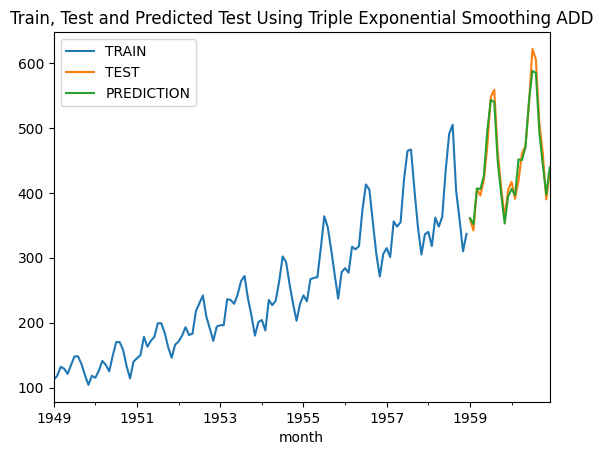

In [14]:

#################################
# Triple Exponential Smoothing (Holt-Winters)
#################################

def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=24)
# 11.99
# carpımsal hata: 15.12

tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(24)

plot_prediction(y_pred, "Triple Exponential Smoothing ADD")



In [42]:

##################################################
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)
##################################################

# p ve q combinations
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arma_model_result = ARIMA(train, order).fit(disp=0)
            aic = arma_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

best_params_aic = arima_optimizer_aic(train, pdq)




Best ARIMANone AIC=inf


In [43]:

# Tune Edilmiş Model
arima_model = ARIMA(train, best_params_aic).fit()




In [44]:
y_pred = arima_model.forecast(24)
mean_absolute_error(test, y_pred)

206.34168103907245

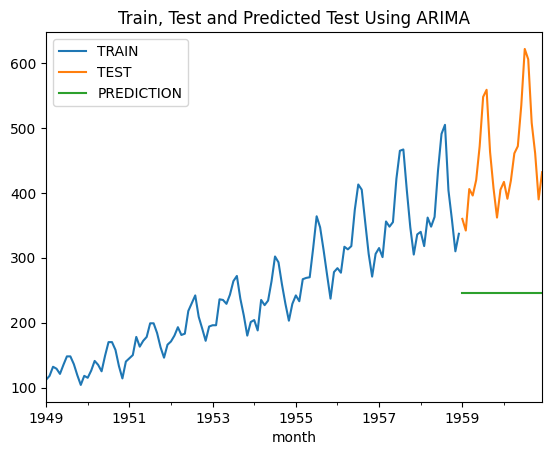

In [45]:

plot_prediction(pd.Series(y_pred, index=test.index), "ARIMA")

In [37]:

##################################################
# SARIMA
##################################################

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), float("inf"), None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order


best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

# Tune Edilmiş Model
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=24)
# pred_ci = y_pred_test.conf_int()
y_pred = y_pred_test.predicted_mean
mean_absolute_error(test, y_pred)
# 63.8447


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1680.2792351899682
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1557.6320531158312
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1060.4792883429307
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1014.0696747520262
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1231.9865853758386
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1185.301097909056
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:969.3781382611883
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:951.6074014199974
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1524.3620853403545
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1403.5942348893623
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:967.5225695583002
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:942.2425093046857
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1136.4998829400497
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1127.8397202214267
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:918.2233876024247
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:896.6964290477107
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1138.8088994229304
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:

68.57726547031133

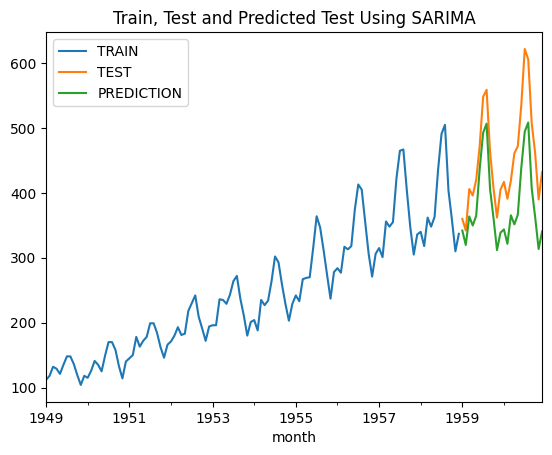

In [38]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")

In [39]:


p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

def sarima_optimizer_mae(train, pdq, seasonal_pdq):
    best_mae, best_order, best_seasonal_order = float("inf"), float("inf"), None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                sarima_model = model.fit(disp=0)
                y_pred_test = sarima_model.get_forecast(steps=24)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)

                # mae = fit_model_sarima(train, val, param, param_seasonal)

                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
                print('SARIMA{}x{}12 - MAE:{}'.format(param, param_seasonal, mae))
            except:
                continue
    print('SARIMA{}x{}12 - MAE:{}'.format(best_order, best_seasonal_order, best_mae))
    return best_order, best_seasonal_order, best_mae

best_order, best_seasonal_order, best_mae = sarima_optimizer_mae(train, pdq, seasonal_pdq)


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAE:452.25
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAE:367.2095457532533
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAE:71.25
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAE:72.62972633845074
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAE:74.93604914677968
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAE:76.79705573389303
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAE:58.59973872393609
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAE:30.626157879495242
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - MAE:442.6732363260292
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - MAE:356.28978563277764
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - MAE:70.49252847732824
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - MAE:71.32051675444973
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - MAE:75.48453207029132
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - MAE:76.43298290267226
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - MAE:61.01388539909843
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - MAE:31.74024174093716
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - MAE:115.25
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - MAE:119.36368436557336
SARIMA(0, 1, 0)x(0, 1, 

In [40]:


model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=24)
y_pred = y_pred_test.predicted_mean
mean_absolute_error(test, y_pred)


30.626157879495242

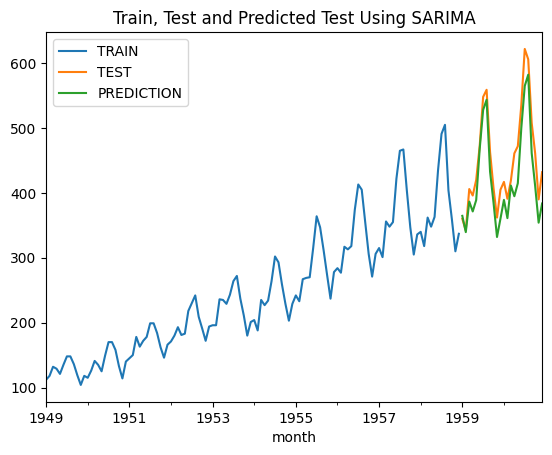

In [41]:
plot_prediction(pd.Series(y_pred, index=test.index), "SARIMA")